# Topic Modeling

This code explores various topic models to extract themes from the processed dosage and administration text. The topic models will be saved to the models/ directory.

In [1]:
#load the packages
import warnings
import pickle
import pandas as pd
from pprint import pprint
import matplotlib.pyplot as plt 

from wordcloud import WordCloud
import pyLDAvis
import pyLDAvis.sklearn

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, TruncatedSVD, LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV

C:\Users\aabel\Envs\drug-labels\lib\site-packages\past\builtins\misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload


## Helper Functions

Function for displaying the topics

In [2]:
# This function comes from the blueprint for text analytics 

def display_topics(model, features, no_top_words=5):
    for topic, words in enumerate(model.components_):
        total = words.sum()
        largest = words.argsort()[::-1] # invert sort order
        print("\nTopic %02d" % topic)
        for i in range(0, no_top_words):
            print("  %s (%2.2f)" % (features[largest[i]], abs(words[largest[i]]*100.0/total)))



Function for displaying the wordcloud

In [3]:
# display word cloud function
def wordcloud_topics(model, features, no_top_words=30):
    for topic, words in enumerate(model.components_):
        size = {}
        largest = words.argsort()[::-1] # invert sort order
        for i in range(0, no_top_words):
            size[features[largest[i]]] = abs(words[largest[i]])
        wc = WordCloud(
            background_color="white", 
            max_words=100,
            width=960, 
            height=540
        )
        wc.generate_from_frequencies(size)
        plt.figure(figsize=(12,12))
        plt.title('Topic ' + str(topic))
        plt.imshow(wc, interpolation='bilinear')
        plt.axis("off")


## Load the data

In [4]:
#load the dataset
df = pd.read_pickle('../data/processed/drugs.pkl')
df.head()

target                                               text  \
0        ORAL  DOSAGE Adults- Take 4 or 6 Pellets by mouth, t...   
1        ORAL  DIRECTIONS Adults: Dissolve 3 to 5 under the t...   
2  OPHTHALMIC  DOSAGE AND ADMINISTRATION The recommended dosa...   
3        ORAL  2 DOSAGE AND ADMINISTRATION Use the lowest eff...   
4     TOPICAL  Directions wet face, apply to hand, massage fa...   

                                              tokens  \
0  [adults, take, pellets, mouth, three, times, d...   
1  [adults, dissolve, tongue, three, times, day, ...   
2  [recommended, regimen, treatment, bacterial, c...   
3  [use, lowest, effective, shortest, duration, c...   
4  [wet, face, apply, hand, massage, face, gently...   

                                          tokens_str  
0  adults take pellets mouth three times daily su...  
1  adults dissolve tongue three times day directe...  
2  recommended regimen treatment bacterial conjun...  
3  use lowest effective shortest duration consist...  
4  wet face apply hand massage face gently rinse ...

## Define Target

Same as the classifier code, we will take the top 5 routes and lump the rest into OTHER. 

In [5]:
#create a new dataframe with just the 5 classes
df.loc[~df['target'].isin(['ORAL', 'TOPICAL', 'INTRAVENOUS', 'DENTAL', 'INTRAMUSCULAR']), 'target'] = 'OTHER'
list(df['target'].unique())

['ORAL', 'OTHER', 'TOPICAL', 'INTRAVENOUS', 'INTRAMUSCULAR', 'DENTAL']

In [6]:
#check the updated value counts
df['target'].value_counts()

ORAL             46628
TOPICAL          27823
OTHER             5241
INTRAVENOUS       2857
DENTAL            1401
INTRAMUSCULAR     1378
Name: target, dtype: int64

## Vectorization

In [7]:
# TF-IDF text vectorization
tfidf_vectorizer = TfidfVectorizer(min_df=5, max_df=0.7)
tfidf_vectors = tfidf_vectorizer.fit_transform(df['tokens_str'])
tfidf_vectors.shape

(85328, 13217)

In [8]:
# Count vectorization (AKA bag-of-words)
count_vectorizer = CountVectorizer(min_df=5, max_df=0.7)
count_vectors = count_vectorizer.fit_transform(df['tokens_str'])
count_vectors.shape

(85328, 13217)


## Non-Negative Matrix Factorization

In [9]:
nmf_model = NMF(n_components=6, random_state=2022)
W_matrix = nmf_model.fit_transform(tfidf_vectors)
H_matrix = nmf_model.components_

display_topics(nmf_model, tfidf_vectorizer.get_feature_names_out())


Topic 00
  take (5.98)
  years (5.94)
  children (5.26)
  doctor (4.08)
  hours (4.03)

Topic 01
  sun (8.59)
  protection (3.34)
  measures (3.24)
  sunscreen (3.02)
  skin (2.97)

Topic 02
  mg (3.14)
  dose (1.71)
  patients (1.40)
  daily (1.06)
  day (1.01)

Topic 03
  hands (8.75)
  product (6.20)
  dry (5.21)
  rub (4.46)
  together (3.63)

Topic 04
  symptoms (10.17)
  pellets (9.81)
  relieved (8.54)
  tongue (8.51)
  dissolve (8.10)

Topic 05
  consult (3.95)
  drops (3.90)
  times (3.58)
  area (3.38)
  affected (3.26)


In [10]:
#compare the nmf model to the original tallys
df['topic'] = W_matrix.argmax(axis=1)
pd.crosstab(df['topic'], df['target'])

target  DENTAL  INTRAMUSCULAR  INTRAVENOUS   ORAL  OTHER  TOPICAL
topic                                                            
0           29              0            0  13314    343      275
1            0              0            0      1     15     5372
2           29           1374         2820  24686   1887      539
3           20              1            1     11    118    10020
4            1              3            0   3850    431       30
5         1322              0           36   4766   2447    11587

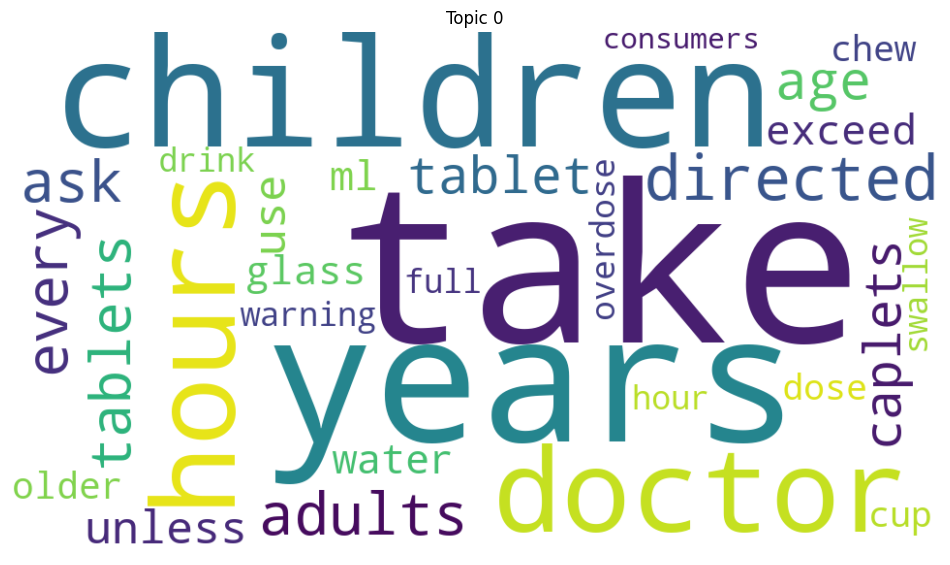

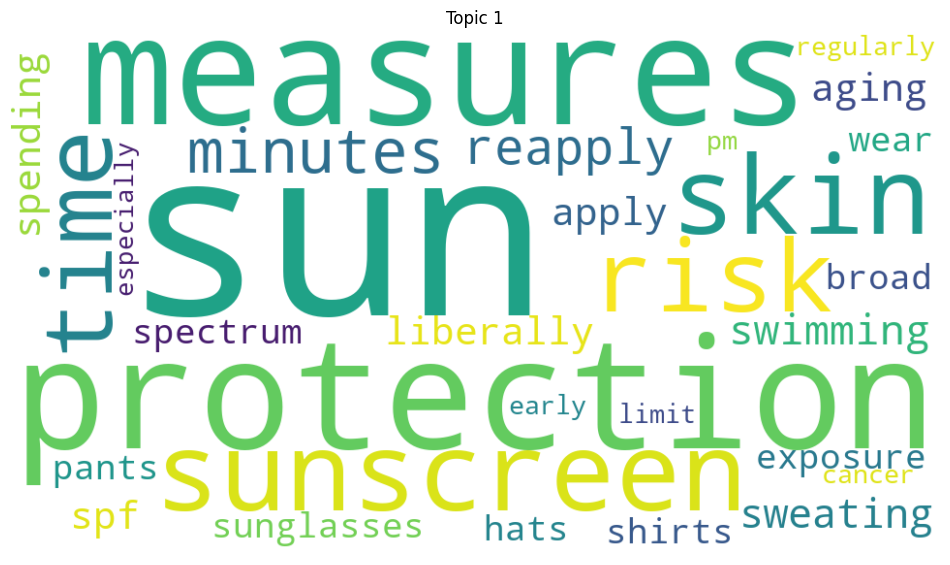

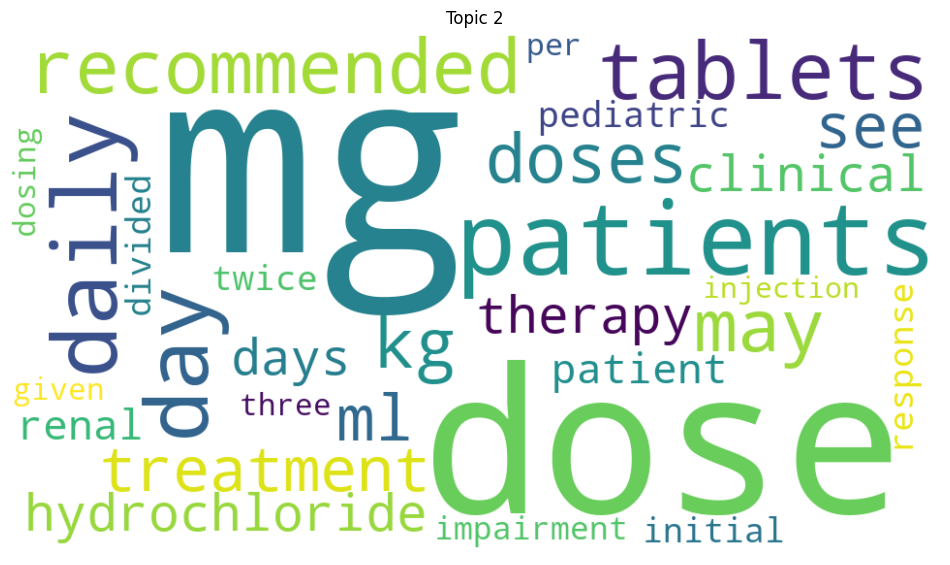

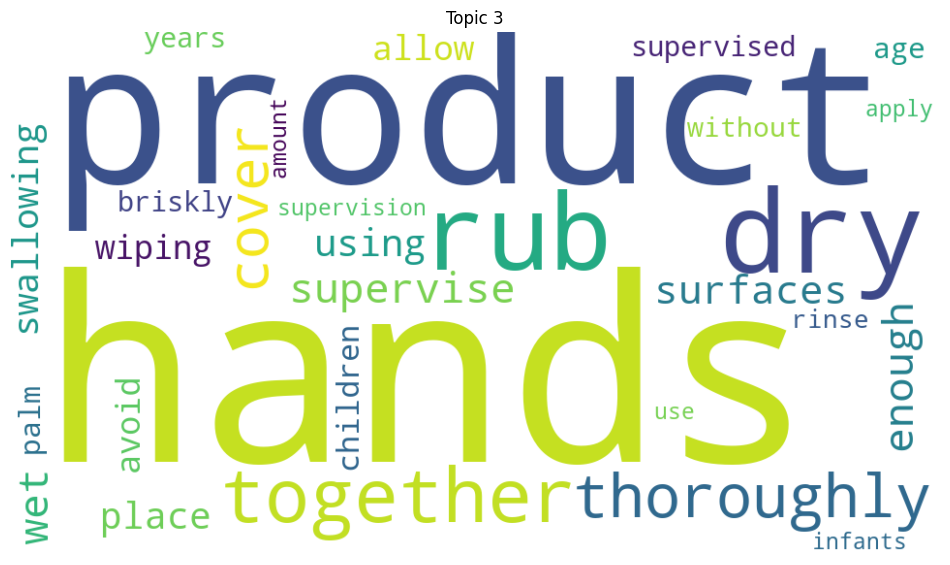

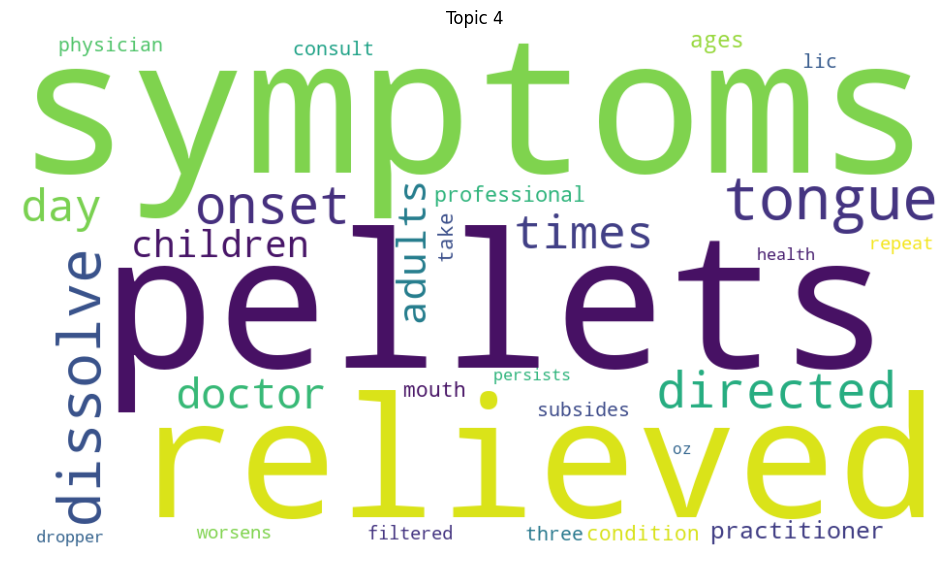

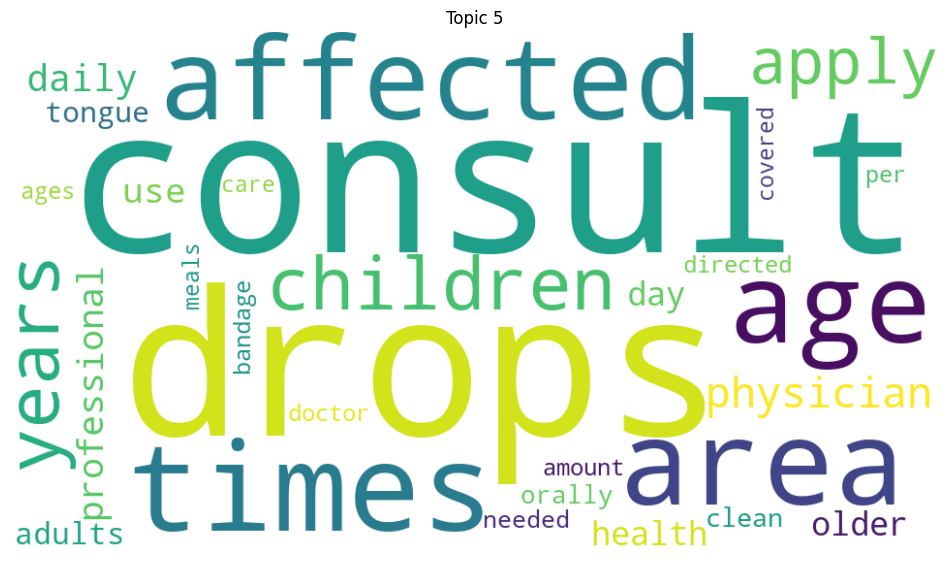

In [11]:
#plot the nmf wordcloud
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    wordcloud_topics(nmf_model, tfidf_vectorizer.get_feature_names_out())

In [12]:
# save model to models/ directory 
with open('../models/nmf_model.pkl', 'wb') as f:
    pickle.dump(nmf_model, f)

## Latent Semantic Analysis

In [13]:
# Fit truncated SVD model (LSA)
svd_model = TruncatedSVD(n_components=6, random_state=2022)
W_svd_matrix = svd_model.fit_transform(tfidf_vectors)
H_svd_matrix = svd_model.components_

# call display_topics on your model
display_topics(svd_model, tfidf_vectorizer.get_feature_names_out())


Topic 00
  children (2.04)
  years (2.00)
  mg (1.47)
  take (1.33)
  doctor (1.32)

Topic 01
  sun (15.77)
  protection (6.11)
  measures (5.92)
  sunscreen (5.54)
  skin (5.51)

Topic 02
  mg (3.90)
  sun (2.53)
  dose (1.93)
  patients (1.79)
  protection (0.99)

Topic 03
  hands (7.52)
  product (5.20)
  dry (4.53)
  rub (3.81)
  together (3.08)

Topic 04
  pellets (10.50)
  tongue (10.44)
  symptoms (9.45)
  relieved (8.95)
  times (8.55)

Topic 05
  area (27.76)
  affected (25.80)
  apply (24.19)
  consult (20.09)
  drops (19.36)


In [14]:
#compare the LSA model to the original tallys
df['topic'] = W_svd_matrix.argmax(axis=1)
pd.crosstab(df['topic'], df['target'])

target  DENTAL  INTRAMUSCULAR  INTRAVENOUS   ORAL  OTHER  TOPICAL
topic                                                            
0         1348            389          780  26899   3109     5875
1            0              0            0      0     11     5302
2            2            987         2076  16130    736      126
3           11              1            1      0    106     9764
4            1              1            0   3002    419       13
5           39              0            0    597    860     6743

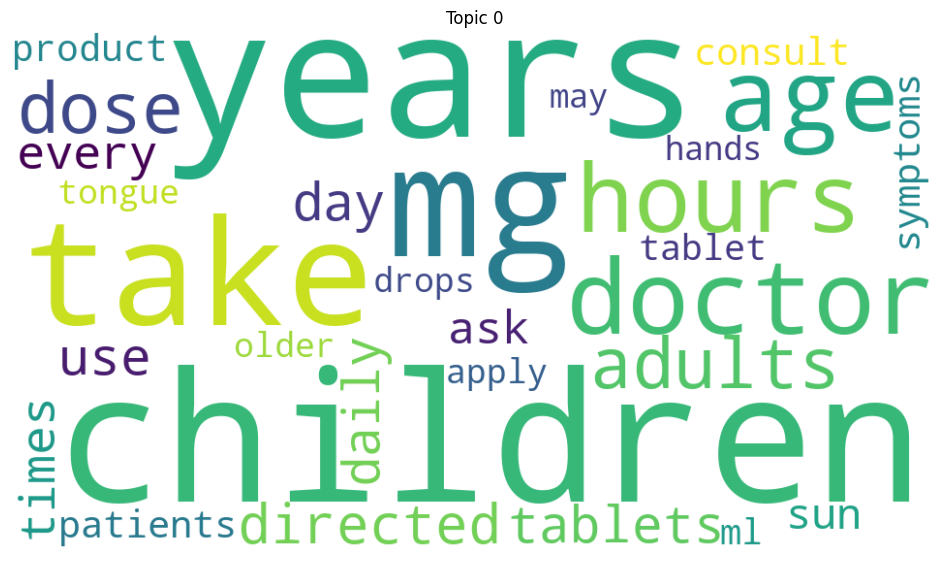

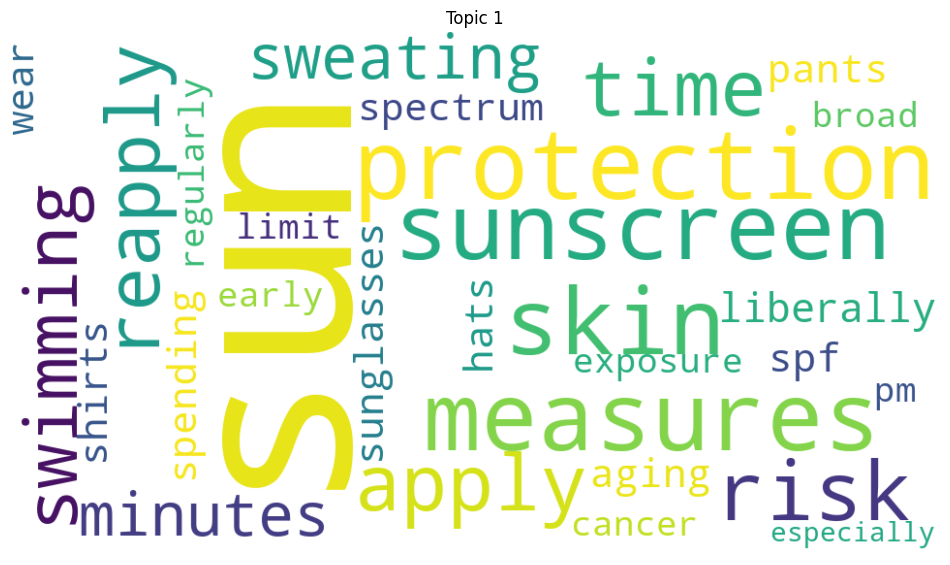

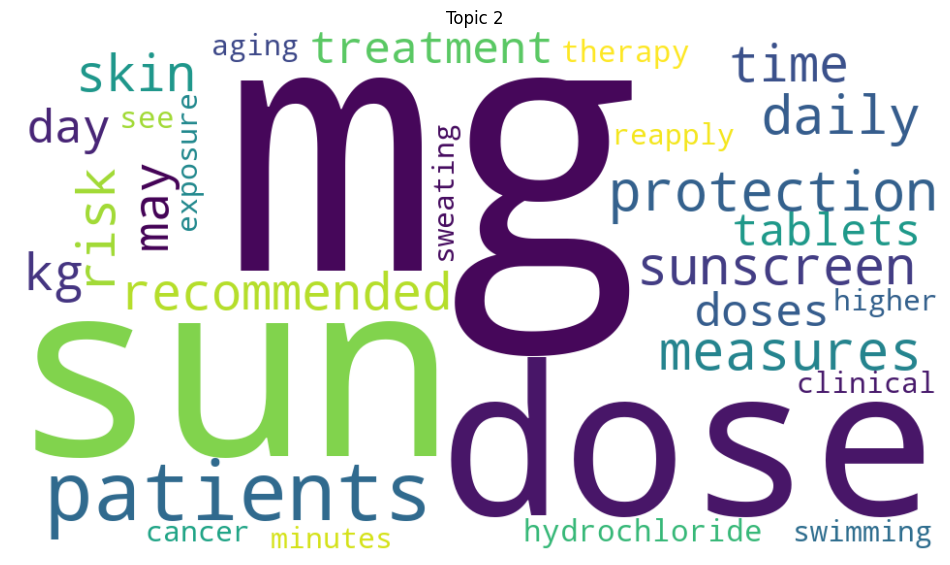

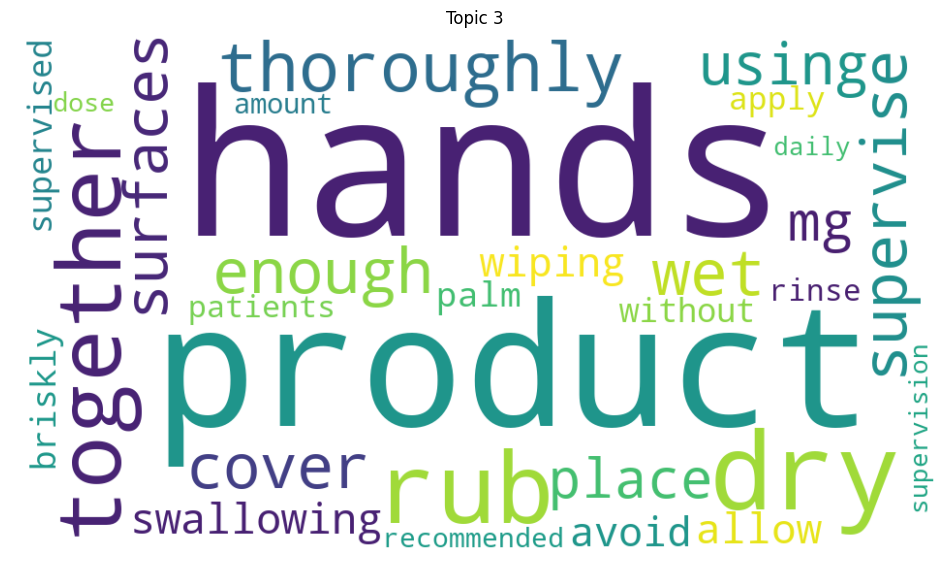

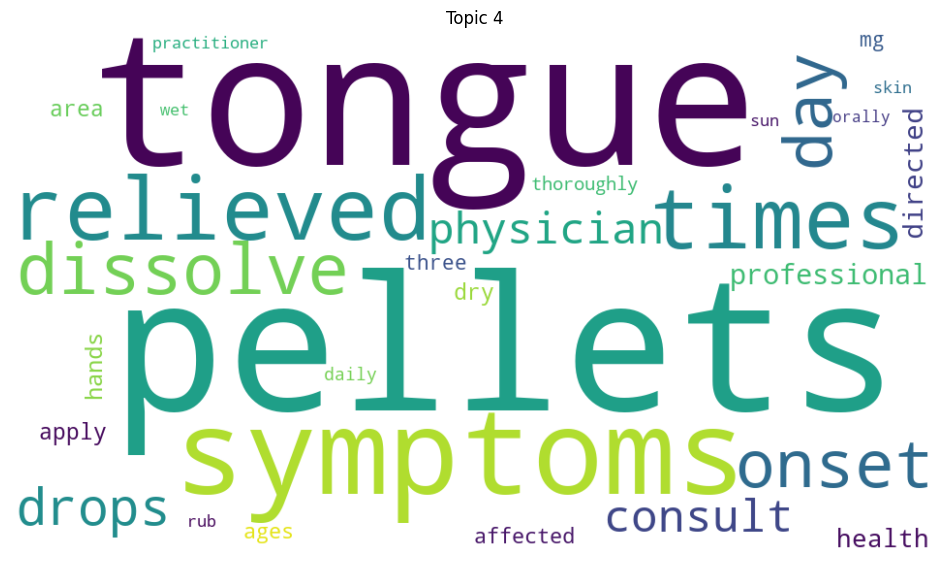

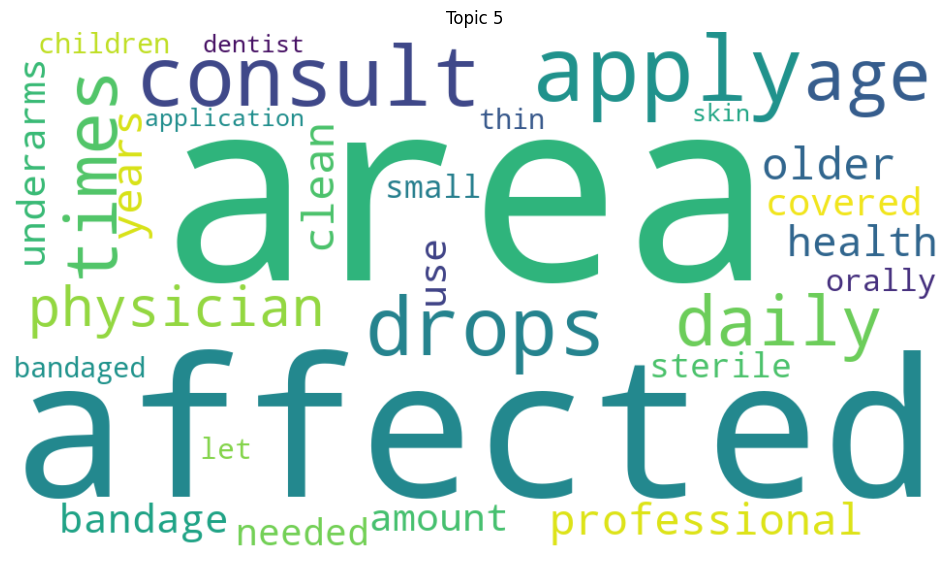

In [15]:
#plot the LSA wordcloud
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    wordcloud_topics(svd_model, tfidf_vectorizer.get_feature_names_out())

In [16]:
# save model to models/ directory 
with open('../models/lsa_model.pkl', 'wb') as f:
    pickle.dump(svd_model, f)

## Latent Dirichlet Allocation

In [17]:
lda_model = LatentDirichletAllocation(n_components=6, random_state=2022)
W_lda_matrix = lda_model.fit_transform(count_vectors)
H_lda_matrix = lda_model.components_

# Call `display_topics` on your fitted model here
display_topics(lda_model, count_vectorizer.get_feature_names_out())


Topic 00
  mg (4.21)
  dose (2.23)
  daily (1.98)
  patients (1.62)
  treatment (1.31)

Topic 01
  mg (6.09)
  dose (4.13)
  patients (2.94)
  day (2.91)
  daily (2.42)

Topic 02
  injection (2.30)
  dose (2.01)
  mg (1.62)
  patients (1.56)
  ml (1.48)

Topic 03
  children (4.60)
  years (4.27)
  use (3.30)
  age (2.55)
  doctor (2.13)

Topic 04
  patient (1.62)
  sun (1.62)
  patients (1.40)
  use (1.39)
  dose (1.33)

Topic 05
  mg (6.86)
  ml (2.71)
  hours (2.67)
  patients (2.64)
  every (2.36)


In [18]:
#compare the LDA model to the original tallys
df['topic'] = W_lda_matrix.argmax(axis=1)
pd.crosstab(df['topic'], df['target'])

target  DENTAL  INTRAMUSCULAR  INTRAVENOUS   ORAL  OTHER  TOPICAL
topic                                                            
0           17            131          395   4284    491     1127
1            0              5           39  13351     61        7
2            7           1173         2364   1414   1147      348
3         1225              0            0  22688   3256    20854
4            1             42            5   1371    119     5127
5          151             27           54   3520    167      360

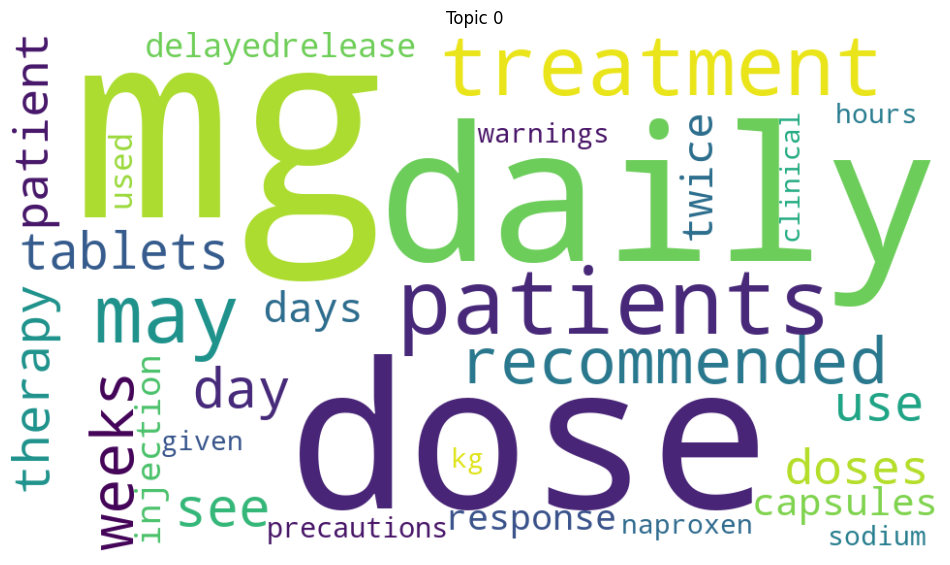

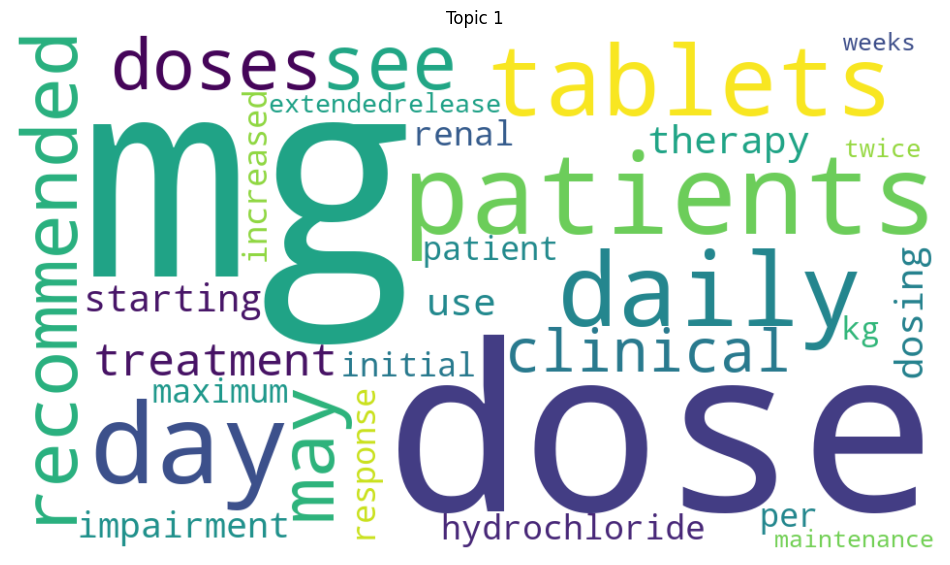

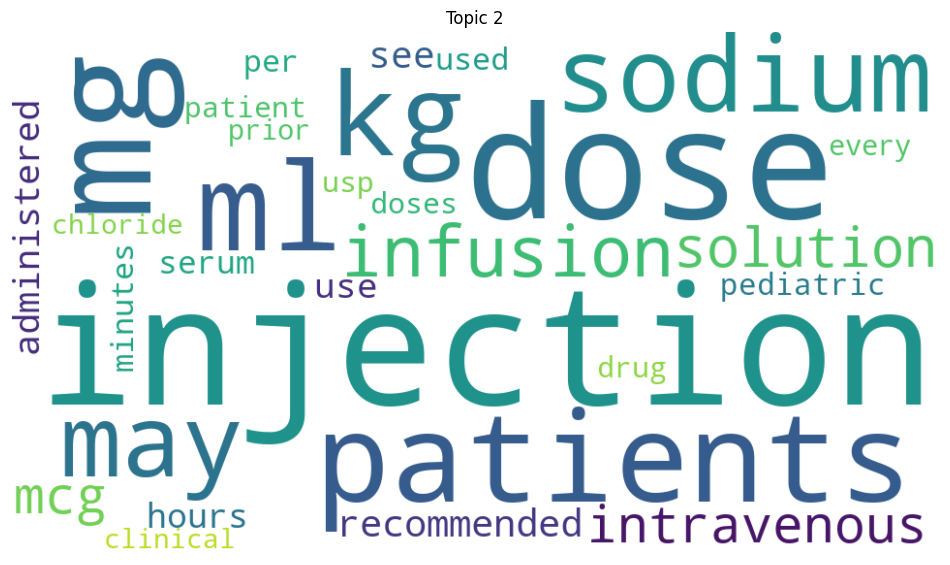

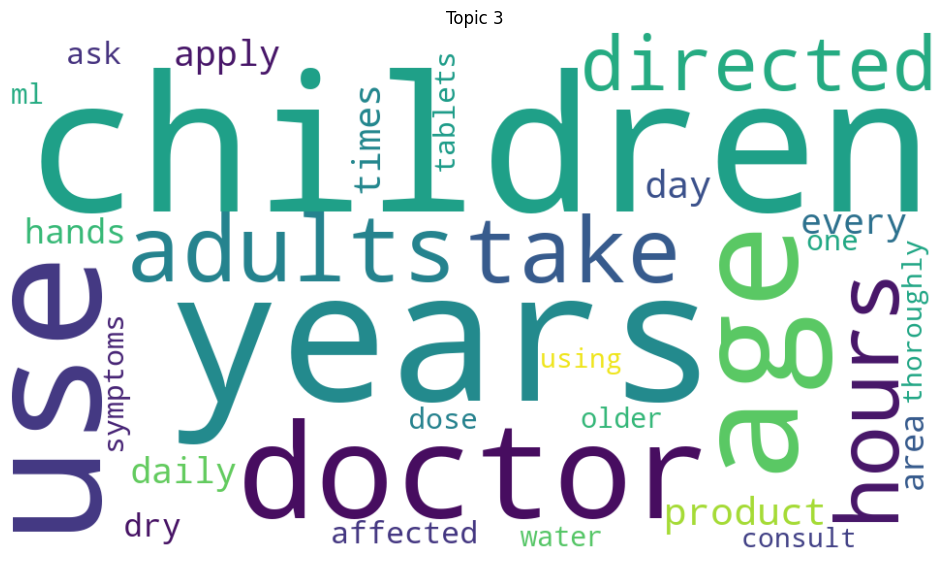

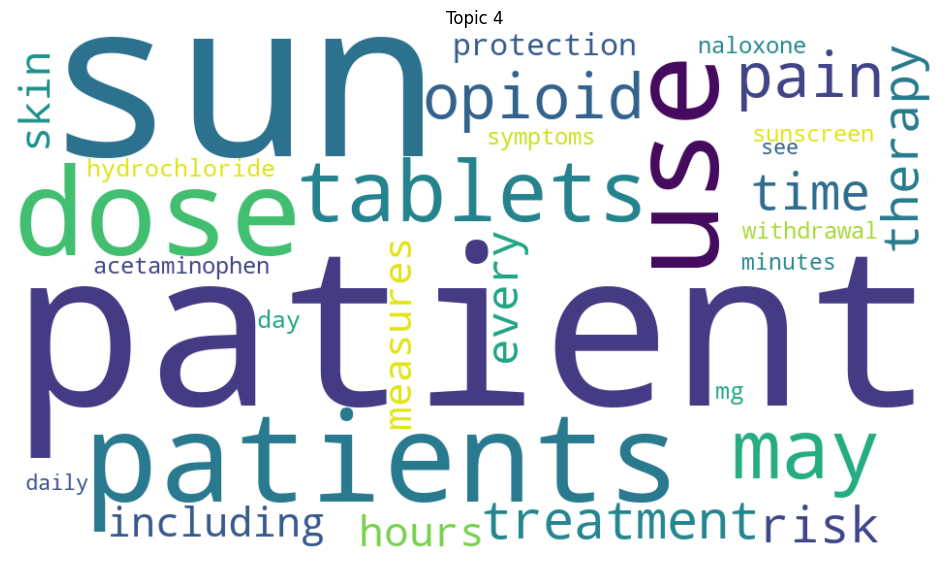

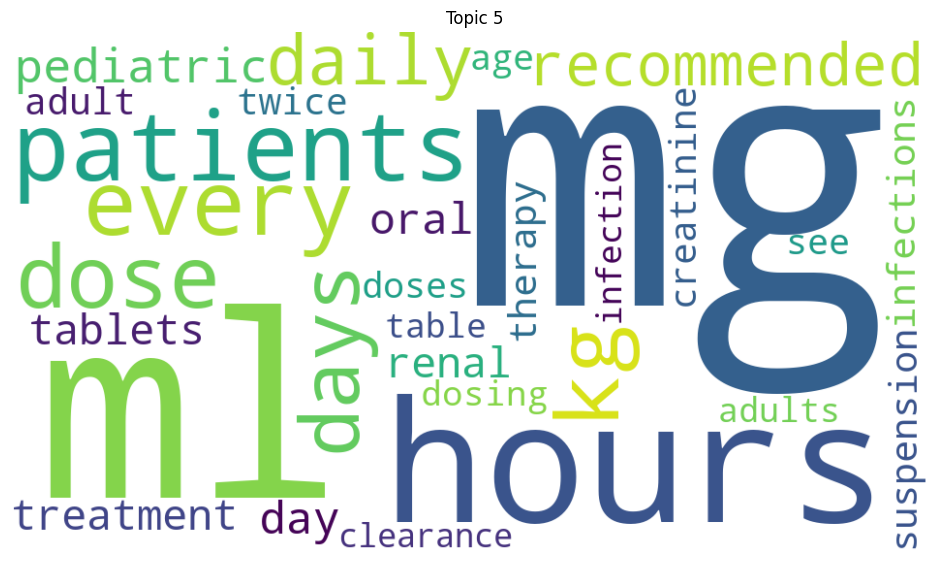

In [19]:
#plot the LDA wordcloud
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    wordcloud_topics(lda_model, count_vectorizer.get_feature_names_out())

In [20]:
lda_display = pyLDAvis.sklearn.prepare(lda_model, count_vectors, count_vectorizer, sort_topics=False)

C:\Users\aabel\Envs\drug-labels\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\aabel\Envs\drug-labels\lib\site-packages\pyLDAvis\_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)


In [21]:
pyLDAvis.display(lda_display)

topics 1,5,4 overlap meaning they are related and not unique , topics 2 and 3 are separated from each other indicating unique topics to get better results will tune the model to see if we can get better unique topics

In [22]:
# save model to models/ directory 
with open('../models/lda_model.pkl', 'wb') as f:
    pickle.dump(lda_model, f)

# save model display to assets/ directory 
pyLDAvis.save_html(lda_display, '../assets/lda_display.html')

In [ ]:
# check the loglikehood score a high score is good
print("Log Likelihood: ", lda_model.score(count_vectors))
# Perplexity score the lower the better
print("Perplexity: ", lda_model.perplexity(count_vectors))
#model parameters
pprint(lda_model.get_params())

Log Likelihood:  -89334091.41221662


In [ ]:
# Define Search Parameters for the grid search
search_params = {'n_components': [6,10,15], 'learning_decay': [.5, .7, .9]}# due to time constraints will limit the max components to 15
# Init the Model
lda = LatentDirichletAllocation()
# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)
# Do the Grid Search
model.fit(count_text_vectors)

In [ ]:
# Best Model parameters
best_lda_model = model.best_estimator_
# Model Parameters
print("Best Model's Params: ", model.best_params_)
# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)
# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(count_text_vectors))

plotting the optimal LDA model

In [ ]:
optimal_lda_text_model = LatentDirichletAllocation(n_components=15,learning_decay=0.7, random_state=2022)
W_lda_text_matrix1 = optimal_lda_text_model.fit_transform(count_text_vectors)
H_lda_text_matrix1 = optimal_lda_text_model.components_

# Call `display_topics` on your fitted model here
display_topics(optimal_lda_text_model, count_text_vectorizer.get_feature_names_out())

In [ ]:
#compare the Optimal LDA model to the original tallys
df['Topic'] = W_lda_text_matrix1.argmax(axis=1)
pd.crosstab(df['Topic'], df['target'])

In [ ]:
#plot the LDAA wordcloud
wordcloud_topics(optimal_lda_text_model, count_text_vectorizer.get_feature_names_out())

the words in the topic are better related with one another

In [ ]:
optimal_lda_display = pyLDAvis.sklearn.prepare(optimal_lda_text_model, count_text_vectors, count_text_vectorizer, sort_topics=False)

In [ ]:
pyLDAvis.display(optimal_lda_display)

In [ ]:
filename = 'optimal_lda_model.pkl'
pickle.dump(optimal_lda_text_model, open('../models/' + filename, 'wb'))

Reference

Prabhakaran, S. (2022, April 28). Lda - how to grid search best topic models? (with examples in python). Machine Learning Plus. Retrieved October 9, 2022, from https://www.machinelearningplus.com/nlp/topic-modeling-python-sklearn-examples/ 

Albrecht, J., Ramachandran, S., &; Winkler, C. (2020). Blueprints for text analytics using Python: Machine Learning-based solutions for common real world (Nlp) applications. O'Reilly. 